## Day 4: Support Vector Machines

In this assignment, you'll write code for and experiment with support vector machines (this is still _supervised_ learning, so our data are labeled). 

SVMs (you might also see "Support Vector Networks") are  classification tools, and they're used primarily for binary classification (that is, deciding whether an input is a member of class A or class B). You can think of this model as representing examples as points in space in such a way that the categories are separated by as big a gap as possible. New points are then assigned a classification based on which side of the gap they live on. 

The above is _linear classification_. SVMs can also perform _nonlinear_ classification, but for this we must use something called the "kernel trick", which essentially maps everything to a much higher dimensional feature space (see the slides for details). 

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from utils import *

import numpy as np
import cvxopt
import matplotlib as mpl
from mpl_toolkits import mplot3d
from matplotlib import pyplot as plt
from sklearn import svm

The optimization problem that we're trying to solve with an SVM is 
$$
\min \frac{1}{n} \sum_{i = 1}^{n} \zeta_i + \lambda \|w\|^2 \\
\text{subject to: } y_i(w \cdot x_i) - b \geq 1 - \zeta_i \\
 \zeta_i \geq 0
$$

This is an example of a _quadratic program_ (QP), since the thing we're trying to minimize is a linearly constrained quadratic problem. Here's an example of a QP:

$$
f(x) = 3 x_1^2 + x_2^2 + 2 x_1x_2 + x_1 + 6x_2 + 2\\
\min f(x) \\
\text{subject to: } 2x_1 + 3x_2 \geq 4 \\
x_1, x_2 \geq 0
$$

Text(0.5,0.92,'example qp')

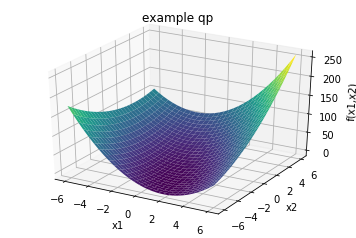

In [2]:
#example by Jeff Heider

def example_qp(x1,x2):
    f = 3*x1**2 + x2**2 + 2*x1*x2 + x1 + 6*x2 + 2
    return f

x1 = np.linspace(-6,6,30)
x2 = np.linspace(-6,6,30)
X1,X2 = np.meshgrid(x1,x2)
Y = example_qp(X1,X2)

fig = plt.figure()
ax = plt.axes(projection = '3d')
ax.plot_surface(X1,X2,Y,rstride =1, cstride=1,cmap='viridis',edgecolor ='none')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('f(x1,x2)')
ax.set_title('example qp')

Here it is from a slightly different angle. Play around with the viewing angle and get an idea of what this function looks like. 

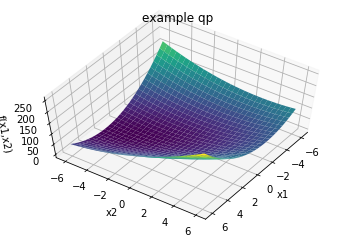

In [3]:
ax.view_init(60,35)
fig

The above is a plot of the unconstrained function. However, we have some constraints that we need to deal with. So, the first thing we do is rewrite the constraints so that they are all have zero on one side: 
$$
g_1 := -2x_1 - 3x_2 + 4 \leq 0 \\
g_2 := -x_1 \leq 0 \\
g_3 := -x_2 \leq 0
$$

Then, we construct the gradients. Recall that the gradient of $f(x_1,x_2)$ is the vector whose first entry is the derivative of $f$ with respect to $x_1$ (that is, $\frac{\partial f}{\partial x_1}$) and the second entry is the derivative of $f$ with respect to $x_2$. 
$$
\nabla f = \begin{bmatrix} 6x_1 + 2x_2 + 1 \\ 2x_1 + 2x_2 + 6 \end{bmatrix}
$$
The gradients of the constraints are 
$$
\nabla g_1 = \begin{bmatrix} -2 \\ -3 \end{bmatrix} , \nabla g_2 = \begin{bmatrix} -1 \\ 0 \end{bmatrix} , \nabla g_3 = \begin{bmatrix} 0 \\ -1 \end{bmatrix}
$$

Now, assume all constraints are satisfied and set the gradient of $f$ to zero and solve.   
$$
6x_1 + 2x_2 = -1 \\
2x_2 + 2x_2 = -6 
$$
Fill in the code below to solve this system. 

In [4]:
grad_f = np.array([[6, 2], [2, 2]])
b = np.array([-1, -6])
x = np.linalg.solve(grad_f,b)
print(x)

[ 1.25 -4.25]


We have two equations and two unknowns.
$$
x_1 = \frac{5}{4}, x_2 = \frac{-17}{4}
$$
This is the solution to the unconstrained problem. However, this violates constraint 1 and constraint 3, so we have to make these constriaints "active". We set them equal to zero:
$$
g_1 = -2x_1 - 3x_2 + 4 = 0 \\
g_3 = -x_2 = 0
$$
and then we solve the following system of equations for $\mu_1, \mu_3, x_1, x_2$:
$$
\nabla f + \mu_1 \nabla g_1 + \mu_3 \nabla g_3 = 0 \\
g_1 = 0 \\
g_3 = 0
$$
That is, 
$$
\begin{bmatrix} 6x_1 + 2x_2 + 1 \\ 2x_1 + 2x_2 + 6 \end{bmatrix} + \mu_1\begin{bmatrix} -2 \\ -3 \end{bmatrix} + \mu_3 \begin{bmatrix} 0 \\ -1 \end{bmatrix} = 0 \\
-2x_1 - 3x_2 + 4 = 0 \\
-x_2 = 0
$$
Fill in the code below to solve this system. 

In [5]:
A = np.array([[6, 2, -2, 0], [2, 2, -3, -1], [-2, -3, 0, 0], [0, -1, 0, 0]])
b = np.array([-1, -6, -4, 0])
x = np.linalg.solve(A,b)
print(x)

[ 2.00000000e+00  3.80647894e-16  6.50000000e+00 -9.50000000e+00]


After solving, you should get 
$$
x_1 = 2 \\
x_2 = 0 \\
\mu_1 = 6.5 \\
\mu_2 = -9.5
$$
We can drop constraint $g_3$ because $\mu_3$ is negative. Fill in the code to solve the system again.

In [7]:
A = np.array([[6, 2, -2], [2, 2, -3], [-2, -3, 0]])
b = np.array([-1, -6, -4])
x = np.linalg.solve(A,b)
print(x)

[0.5 1.  3. ]


You should get
$$
x_1 = .5 \\
x_2 = 1 \\
\mu_1 = 3 \\
$$
Fill in the code below to find what the minimum function value is.

In [8]:
f = example_qp(.5,1)
print(f)

11.25


You should get a value of $11.25$. After verifying linear dependence of the gradient and uniqueness of the solution (which you don't have to do for this assignment), we say that this local minimum is the global min of the objective function, given the above constraints. 

In python, there is an easier way to solve QPs: use the package __cvxopt__. The function __cvxopt.solvers.qp__ solves 
$$
\min \frac{1}{2} x^T Px + q^Tx \\
\text{subject to: } Gx \leq h \\
Ax = b
$$

For our problem, that means 
$$
P = \begin{bmatrix} 6 & 2 \\ 2 & 2 \end{bmatrix}, q = \begin{bmatrix} 1 \\ 6 \end{bmatrix},  G = \begin{bmatrix} -2 & -3 \\ -1 & 0 \\ 0 & -1 \end{bmatrix}, h = \begin{bmatrix} -4 \\ 0 \\ 0 \end{bmatrix}
$$
Fill in the matrices below (P,q,G,h) to solve the system.

In [14]:
P = np.array(([6.,2.],[2.,2.]))
q = np.array(([1.],[6.]))
G = np.array(([-2.,-3.],[-1.,0.],[0.,-1.]))
h = np.array(([-4.],[0.],[0.]))

P = cvxopt.matrix(P)
q = cvxopt.matrix(q)
G = cvxopt.matrix(G)
h = cvxopt.matrix(h)
#A,b = cvxopt.matrix(np.zeros(1)), cvxopt.matrix(np.zeros(1))

#print(P)
#print(q)
#print(G)
#print(h)
solution = cvxopt.solvers.qp(P, q, G, h)
print("x1,x2 =", np.ravel(solution['x']))

     pcost       dcost       gap    pres   dres
 0:  2.4299e+00  1.1771e+01  1e+01  2e+00  1e+00
 1:  9.5508e+00  8.1393e+00  1e+00  3e-16  9e-16
 2:  9.2569e+00  9.2273e+00  3e-02  9e-17  0e+00
 3:  9.2501e+00  9.2498e+00  3e-04  2e-16  5e-16
 4:  9.2500e+00  9.2500e+00  3e-06  2e-16  1e-15
Optimal solution found.
x1,x2 = [0.50000063 0.99999966]


The optimal solution found by the convex solver should be the same as the one we found earlier. You'll do more with __cvxopt__ tomorrow.

Today we will be using __scikit-learn__ to experient and play with different kernels. Here we have some clearly separable binary data.

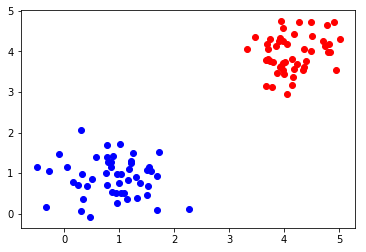

In [15]:
dim = 2
colors = ['red','blue']
# 2-D mean of ones
M1 = np.ones((dim,))
# 2-D mean of threes
M2 = 4 * np.ones((dim,))
# 2-D covariance of 0.3
C1 = np.diag(0.3 * np.ones((dim,)))
# 2-D covariance of 0.2
C2 = np.diag(0.2 * np.ones((dim,)))

def generate_gaussian(m, c, num):
    return np.random.multivariate_normal(m, c, num)

def plot_data_with_labels(x, y):
    unique = np.unique(y)
    for li in range(len(unique)):
        x_sub = x[y == unique[li]]
        plt.scatter(x_sub[:, 0], x_sub[:, 1], c = colors[li])
    plt.show()
    
num = 50
x1 = generate_gaussian(M1, C1, num)
y1 = np.ones((x1.shape[0],))
x2 = generate_gaussian(M2, C2, num)
y2 = -np.ones((x2.shape[0],))
x = np.concatenate((x1, x2), axis = 0)
y = np.concatenate((y1, y2), axis = 0)
#print('x {} y {}'.format(x.shape, y.shape))
plot_data_with_labels(x, y)

The code below performs the svm optimization. 

In [16]:
clf = svm.SVC(kernel = 'linear', C = 1000)
clf.fit(x,y)

#predict new values
new1 = [[.5,1]]
new2 = [[6,3]]
print(clf.predict(new1))
print(clf.predict(new2))

[1.]
[-1.]


In [17]:
#get support vectors
vectors = clf.support_vectors_
print(vectors)

[[3.66394147 3.15270399]
 [1.71698993 1.5266346 ]]


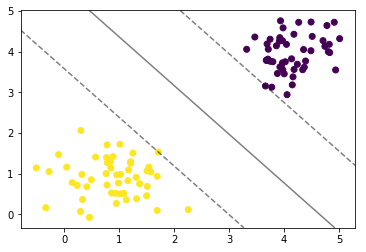

In [18]:
#plot
plt.scatter(x[:,0],x[:,1],c = y)
# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none')
plt.show()